In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#from os import environ
#environ['KERAS_BACKEND'] = 'theano'
#import theano
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Activation,Dropout,Input
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM
# from keras_tqdm import TQDMNotebookCallback
from ipywidgets import interact

# from bokeh.io import push_notebook, show, output_notebook
# from bokeh.plotting import figure
# output_notebook()

np.random.seed(7)
get_ipython().magic('matplotlib inline')

print("All dependencies imported!! TensorFlow : {} ; Keras :{}".format(tf.__version__,keras.__version__))

get_ipython().system('(date +%d\\ %B\\ %G)')

Using TensorFlow backend.


All dependencies imported!! TensorFlow : 1.0.0 ; Keras :2.0.5
27 June 2017


In [2]:
def plot_data_stats(rucio_data):
    sns.set_context('poster')
    
    ax = sns.countplot(x='activity',data= rucio_data)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()
    gx= sns.countplot(x='transfer-endpoint', data = rucio_data)
    gx.set_xticklabels(gx.get_xticklabels(), rotation=30)
    plt.show()
    vx = sns.countplot(x='protocol', data = rucio_data)
    plt.show()
    bx= sns.countplot(x='src-type', data=rucio_data)
    plt.show()
    cx= sns.countplot(x='dst-type', data=rucio_data)
    plt.show()

def train_encoders(rucio_data):
    
    if os.path.isfile('encoders/src.npy'):
        print('using cached LabelEncoders for encoding data.....')
        src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
    else:
        print('No cached LabelEncoders found!! training some new ones....')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        scope_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        scope_encoder.fit(rucio_data['scope'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/scope.npy', scope_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def load_encoders(path='encoders/'):
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    scope_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/src.npy')
    dst_encoder.classes_ = np.load('encoders/dst.npy')
    scope_encoder.classes_ = np.load('encoders/scope.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, encoders=None):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')

    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # Normalization
    
    #filesize_max = np.max(rucio_data['bytes'].as_matrix())
    filesize_mean = np.mean(rucio_data['bytes'].as_matrix())
    filesize_std = np.std(rucio_data['bytes'].as_matrix())
    
    delay_mean = np.mean(rucio_data['delay'].as_matrix())
    delay_std = np.std(rucio_data['delay'].as_matrix())
    
    rucio_data['bytes'] = (rucio_data['bytes'] - filesize_mean) / filesize_std
    rucio_data['delay'] = (rucio_data['delay'] - delay_mean) / delay_std
    
    # encode categorical data
 
    src_encoder,dst_encoder,scope_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['scope'] = scope_encoder.transform(rucio_data['scope'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data


# # Load and preprocess data

# In[12]:

def get_and_preprocess_data(path='data/atlas_rucio-events-2017.06.01.csv'):
    
    rucio_data = pd.read_csv(path)
    rucio_data = rucio_data[:700000]
    rucio_data = preprocess_data(rucio_data)
    durations = rucio_data['duration']
    rucio_data = rucio_data.drop(['duration'], axis=1)
    inputs = rucio_data.as_matrix()
    outputs = durations.as_matrix()
    print(inputs.shape, outputs.shape)
    return inputs, outputs

# # splitting data into test and training set

# In[14]:

def split_data(rucio_data,durations, num_timesteps=50, split_frac=0.9):
    
#     slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0])
    n_examples = rucio_data.shape[0]
    n_batches = (n_examples - num_timesteps )
    print('Total Batches : {}'.format(n_batches))
    
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = rucio_data[i:i+num_timesteps]
        w = durations[i+num_timesteps]
        inputs.append(v)
        outputs.append(w)
    
    inputs = np.stack(inputs)
    outputs = np.stack(outputs)
    print(inputs.shape, outputs.shape)
    
    split_idx = int(inputs.shape[0]*split_frac)
    trainX, trainY = inputs[:split_idx], outputs[:split_idx]
    testX, testY = inputs[split_idx:], outputs[split_idx:]
    print('Training Data shape:',trainX.shape, trainY.shape)
    print('Test Data shape: ',testX.shape, testY.shape)
    return trainX, trainY, testX, testY

import keras.callbacks as cb

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


import time
def run_network(model=None,data=None, epochs=1,n_timesteps=30, batch=128):
    
    print('\n Loading data...')
    if data is None:
        rucio_data, durations = get_and_preprocess_data()

        print('\n Data Loaded and preprocesses!!....')
        print('\n Moving on to splitting and reshaping data...')
        trainX, trainY, testX, testY = split_data(inputs, outputs,batch_size=batch,num_timesteps=n_timesteps, split_frac=0.9)
        print('\n Data split into train and test sets.. ')
    else:
        trainX, trainY, testX, testY = data
        print('\n Data split into train and test sets.. ')

    try:
        start_time = time.time()
        
        if model is None:
            model = build_model(n_timesteps)

            history = LossHistory()

            print('Training model...')
            training = model.fit(trainX, trainY, epochs=epochs, batch_size=batch,
                                 validation_split=0.1, callbacks=[history], verbose=1)

            print("Training duration : {0}".format(time.time() - start_time))
            #score = model.evaluate(trainX, trainY, verbose=0)

            #print("Network's training score [MSE]: {0} ; [in seconds]: {1}".format(score,np.sqrt(score)))
            print("Training finished !!!!!!")
            
#             print('\n Saving model to disk..')
#             # serialize model to JSON
#             model_json = model.to_json()
#             with open("models/lstm_model.json", "w") as json_file:
#                 json_file.write(model_json)
#             # serialize weights to HDF5
#             model.save_weights("models/lstm_model.h5")
#             print("Saved model to disk")
            return training, data, model, history.losses
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return model, history.losses
    
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
#     fig.savefig('plots/batch_loss.jpg')
    print(len(losses))
    fig.show()




# np.save('models/batch_losses.npy', losses)


# In[44]:

# score = model.evaluate(trainX, trainY, verbose=0)

# print("Network's training score [MSE]: {0}, in seconds : {1}".format(score, np.sqrt(score)))


# # # Reloading Saved MOdel

# # In[45]:

# # load json and create model
# json_file = open('models/lstm_model.json', 'r')
# loaded_model_json = json_file.read()
# # json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("models/lstm_model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss="mse", optimizer="rmsprop")
# print('Model model compiled!!')


# In[46]:

# score = loaded_model.evaluate(trainX, trainY, verbose=0)

# print("Network's training score [MSE]: {0}, in seconds : {1}".format(score, np.sqrt(score)))


# # Plotting Performance

# In[47]:

#sns.set_context('poster')

#plt.plot(training.history['loss'])
#plt.plot(training.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validate'], loc='upper right')
#plt.savefig('plots/losses.jpg')


# In[48]:

# trainX, trainY, testX, testY = data
# score = model.evaluate(testX, testY, verbose=2)

# print('Test Set Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

# predictions=model.predict(testX)
# np.save('models/predictions.npy', predictions)
# np.save('models/testY.npy', testY)
# np.save('models/testX.npy', testX)
#plt.plot(predictions[0:300],'y' )
#plt.plot(testY[0:300], 'g')

#plt.savefig('plots/results.jpg')
#plt.plot(predictions[:100],'y' )
#plt.plot(testY[:100], 'g')

#plt.savefig('plots/results_100.jpg')


# In[54]:

# mae = testY-predictions
# print('max error : {} ; min error : {} ; Mean Error: {}'.format(np.max(mae), np.min(mae), np.mean(mae)))
# #plt.plot(mae,'r')
# #plt.savefig('plots/mae.jpg')
# np.save('models/mae.npy', mae)
# print('ALLL DONE!!!')


In [3]:
pd.__version__


'0.20.2'

In [4]:
x, y = get_and_preprocess_data()

using cached LabelEncoders for encoding data.....
(700000, 10) (700000,)


In [5]:
def build_model(num_timesteps=50):

    model = Sequential()
    layers = [512, 512, 512, 256, 1]
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 10), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[2]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [6]:
data = split_data(x, y, num_timesteps=30)

700000
Total Batches : 699970
(699970, 30, 10) (699970,)
Training Data shape: (629973, 30, 10) (629973,)
Test Data shape:  (69997, 30, 10) (69997,)


# Network -- LSTM|512 LSTM|512 Dense|512 Dense|256 O/p

### timesteps = 30


 Loading data...

 Data split into train and test sets.. 
Compilation Time :  0.021353721618652344
Training model...
Train on 566975 samples, validate on 62998 samples
Epoch 1/3
566975/566975 [==============================] - 624s - loss: 24267.9935 - val_loss: 11254.3969
Epoch 2/3
566975/566975 [==============================] - 623s - loss: 22819.2688 - val_loss: 11182.6467
Epoch 3/3
566975/566975 [==============================] - 623s - loss: 22096.3326 - val_loss: 11828.4980
Training duration : 1873.9836566448212
Training finished !!!!!!
3324


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


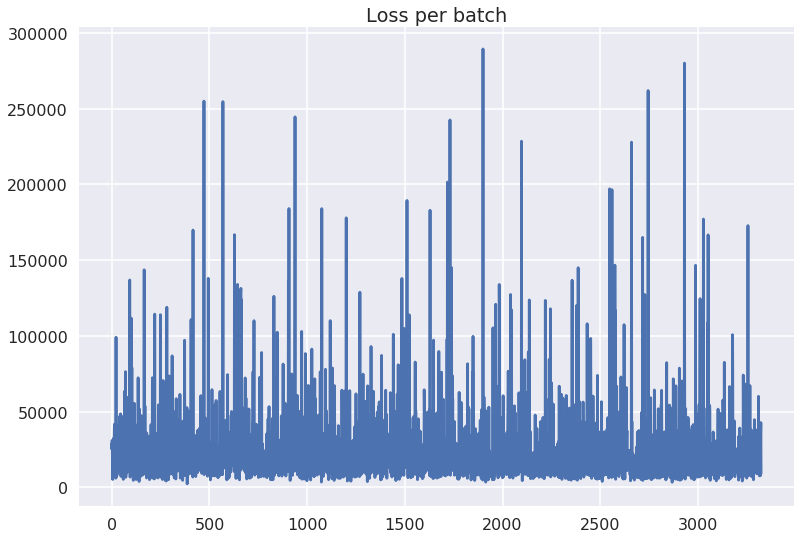

In [7]:
training, data, model, losses = run_network(data=data, epochs=3, batch=512,n_timesteps=30)
trainX, trainY, testX, testY = data
plot_losses(losses)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


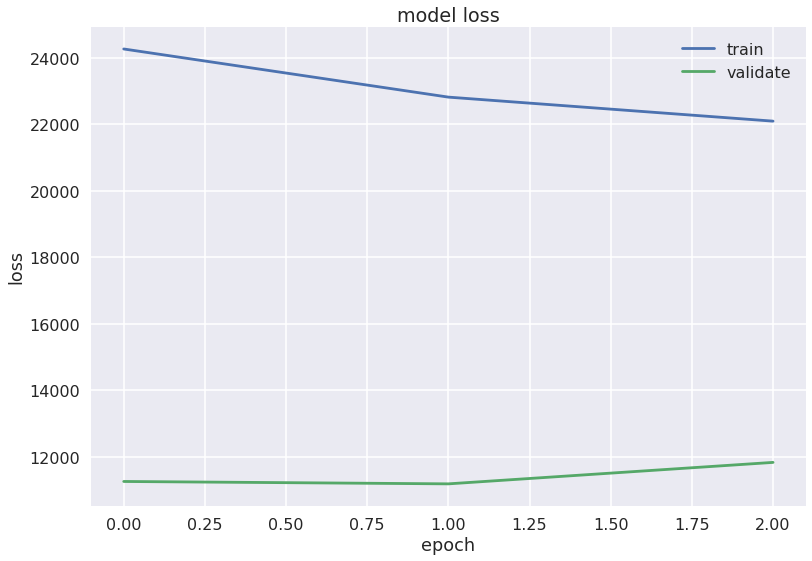

In [8]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

69984/69997 [============================>.] - ETA: 0sResults: MSE - 17259.435113  ;  seconds = 131.375
Train score MSE - 20980.378894 ; seconds = 144.846
[   21.91830063    22.05853653    22.17049408 ...,  1091.62792969
  1168.22937012  1226.23828125]


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


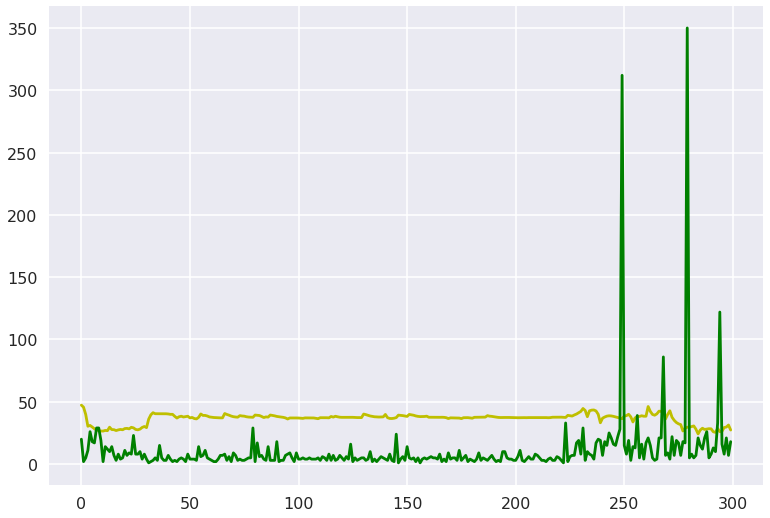

In [9]:
trainX, trainY, testX, testY = data
score = model.evaluate(testX, testY, verbose=1)
print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))
train_score = model.evaluate(trainX, trainY, verbose =0)
print('Train score MSE - {:.6f} ; seconds = {:.3f}'.format(train_score, np.sqrt(train_score)))

predictions=model.predict(testX)
print(np.unique(predictions))
plt.plot(predictions[0:300],'y' )
plt.plot(testY[0:300], 'g')

plt.show()

69790


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


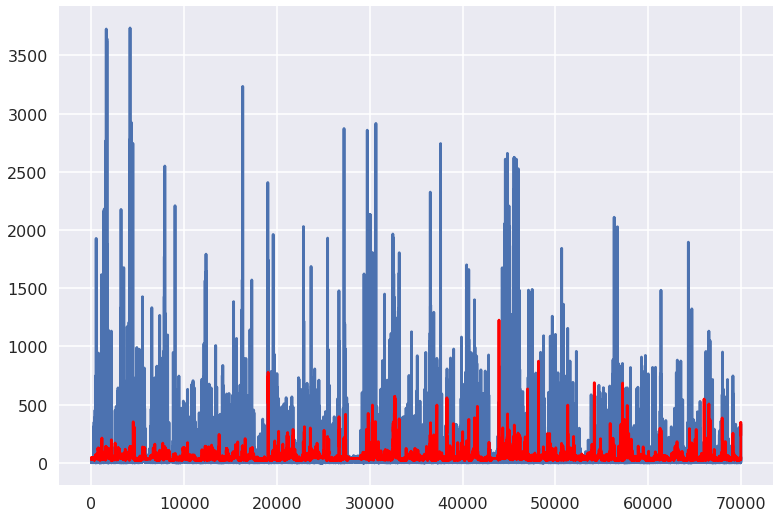

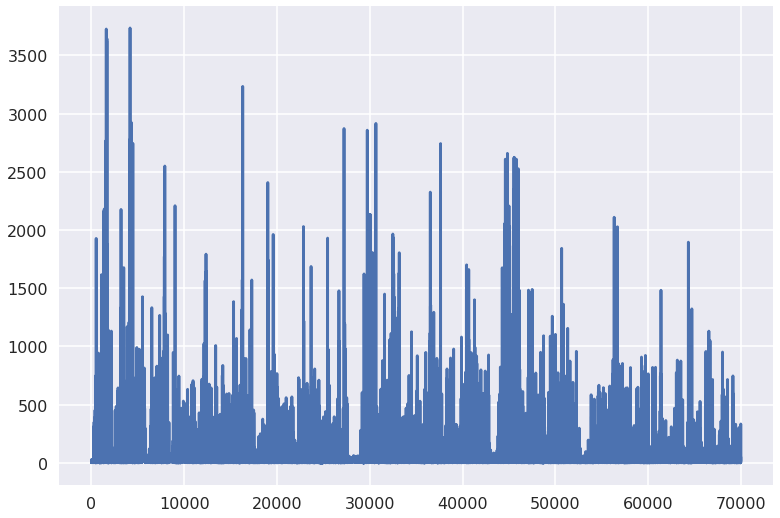

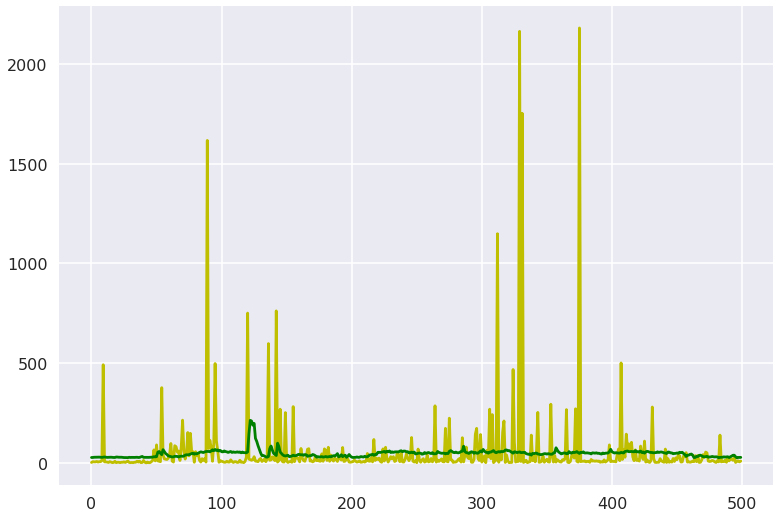

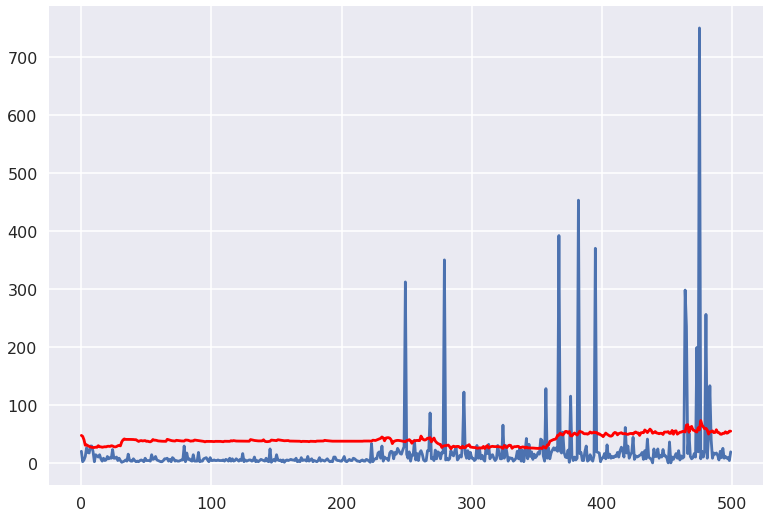

In [22]:
print(len(np.unique(predictions)))
plt.plot(testY)
plt.plot(predictions, 'r')
plt.show()

plt.plot(testY)
plt.show()

plt.plot(testY[1000:1500], 'y')
plt.plot(predictions[1000:1500], 'g')
plt.show()

plt.plot(testY[:500])
plt.plot(predictions[:500], 'r')
plt.show()

# plt.plot(predictions[:00], 'r')



max :  3610.09483337 min : -1209.23828125 mean:  -2.82175658467 std: 131.344862105


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


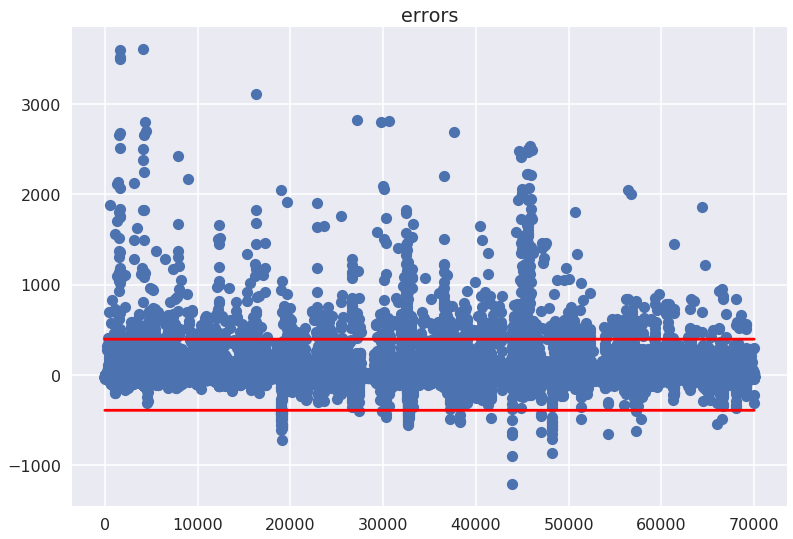

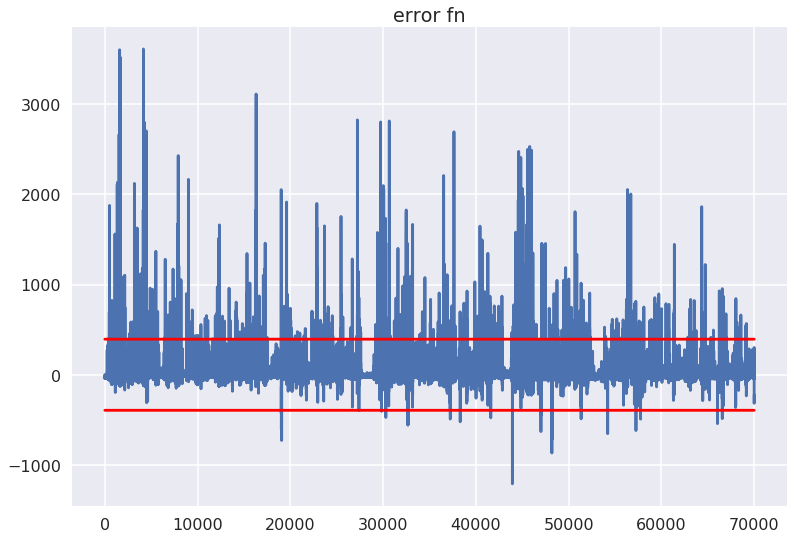

In [30]:
mae=np.subtract(np.reshape(testY, [len(testY), 1]), predictions)
print('max : ',np.max(mae),'min :', np.min(mae),'mean: ', np.mean(mae), 'std:', np.std(mae))
# std = np.std(mae)
std = np.full(len(mae), np.std(mae))
plt.plot(mae,'o')
# plt.plot(3*std, 'r')
# plt.plot(-3*std, 'r')
plt.title('errors')
plt.show()

plt.plot(mae)
# plt.plot(3*std, 'r')
# plt.plot(-3*std, 'r')
plt.title('error fn')
plt.show()

# A stateful model with the same architecture

In [62]:
def build_model(num_timesteps=50):

    model = Sequential()
    layers = [512, 512, 256, 256, 128, 1]
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 10), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[5]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [58]:
x, y = get_and_preprocess_data()
data = split_data(x,y, num_timesteps=30)

using cached LabelEncoders for encoding data.....
(700000, 10) (700000,)
700000
Total Batches : 699970
(699970, 30, 10) (699970,)
Training Data shape: (629973, 30, 10) (629973,)
Test Data shape:  (69997, 30, 10) (69997,)



 Loading data...

 Data split into train and test sets.. 
Compilation Time :  0.020662546157836914
Training model...
Train on 566975 samples, validate on 62998 samples
Epoch 1/2
566975/566975 [==============================] - 769s - loss: 28866.4261 - val_loss: 12045.0611
Epoch 2/2
566975/566975 [==============================] - 768s - loss: 28831.7183 - val_loss: 11866.2962
Training duration : 1541.8606970310211
Training finished !!!!!!
1108


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


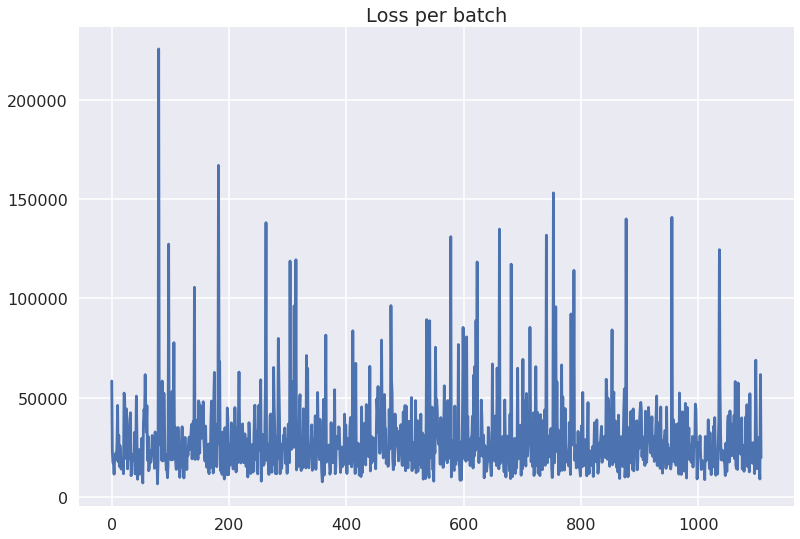

In [ ]:
training, data, model, losses = run_network(data=data, epochs=2, batch=1024,n_timesteps=30)
trainX, trainY, testX, testY = data
plot_losses(losses)

In [64]:
print(9)

9


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


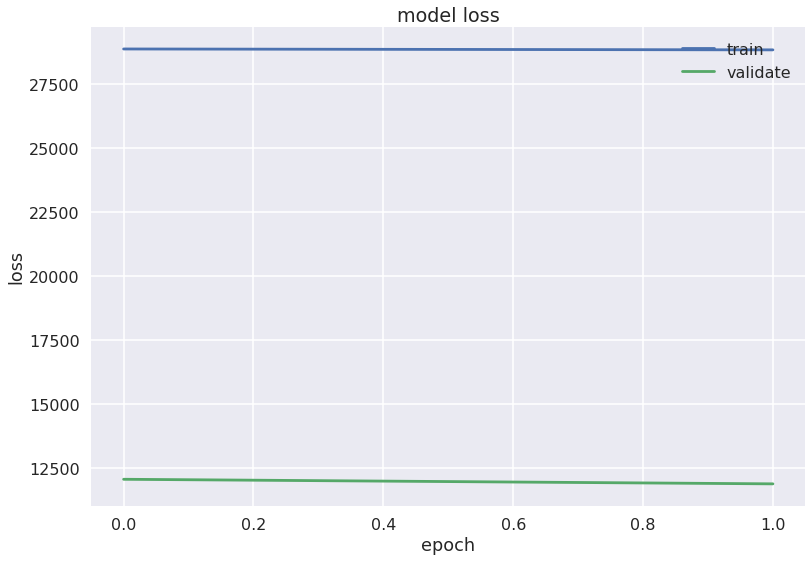

In [65]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

Results: MSE - 18867.592578  ;  seconds = 137.359
Train score MSE - 27131.710167 ; seconds = 164.717
[ 47.39580536]


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


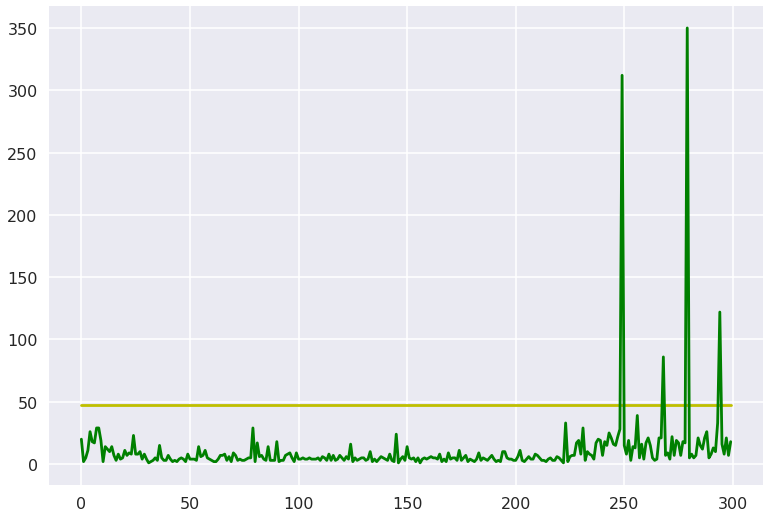

In [67]:
# trainX, trainY, testX, testY = data
# score = model.evaluate(testX, testY, verbose=1)
print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))
# train_score = model.evaluate(trainX, trainY, verbose =1)
print('Train score MSE - {:.6f} ; seconds = {:.3f}'.format(train_score, np.sqrt(train_score)))

predictions=model.predict(testX)
print(np.unique(predictions))
plt.plot(predictions[0:300],'y' )
plt.plot(testY[0:300], 'g')

plt.show()

1


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


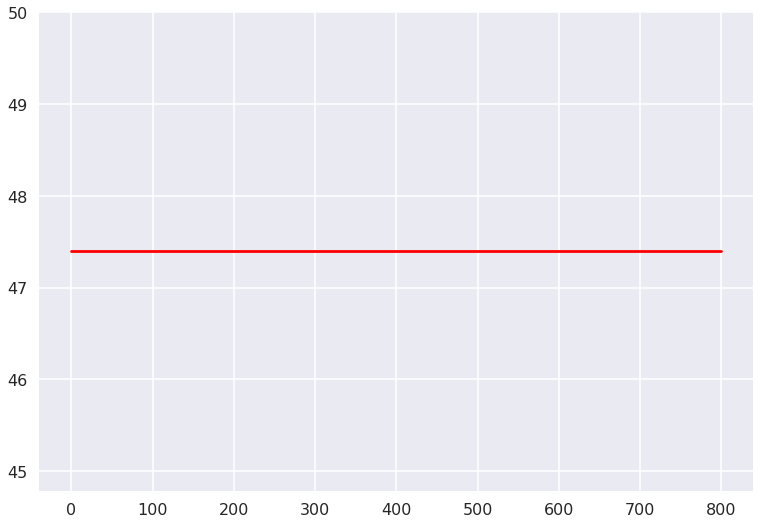

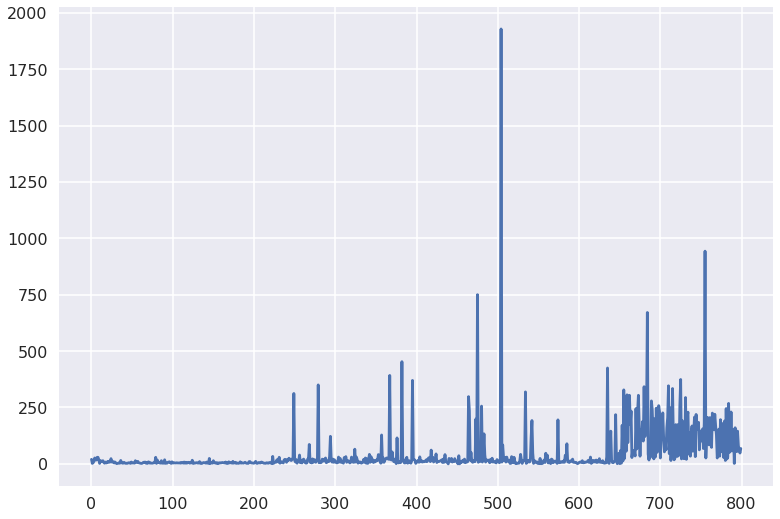

In [68]:
print(len(np.unique(predictions)))
plt.plot(predictions[:800], 'r')
# plt.plot(testY[:800])
plt.show()

# plt.plot(predictions[:800], 'r')
plt.plot(testY[:800])
plt.show()


3688.60419464 -47.3958053589


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


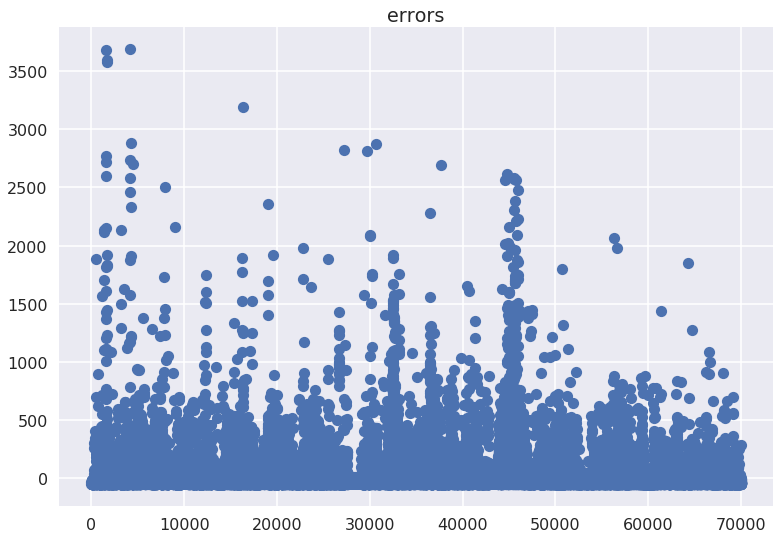

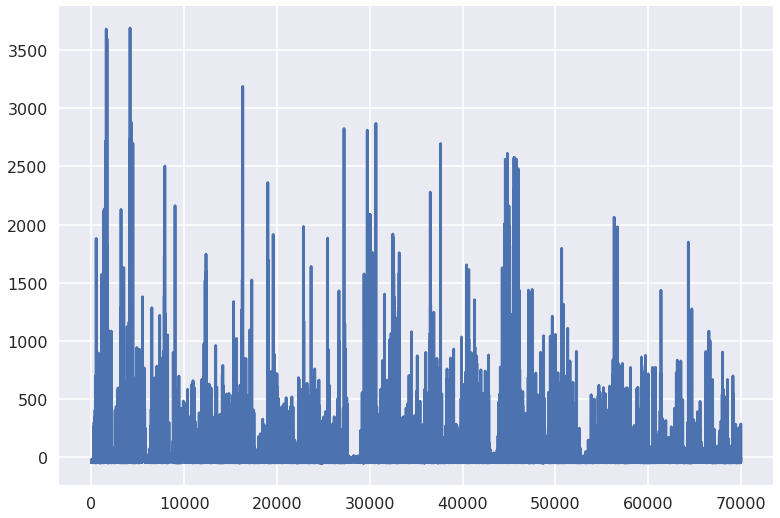

In [69]:
mae=np.subtract(np.reshape(testY, [len(testY), 1]), predictions)
print(np.max(mae), np.min(mae))

plt.plot(mae, 'o')
plt.title('errors')
plt.show()

plt.plot(mae)
plt.show()

# timesteps = 10 ; same model--

In [70]:
def build_model(num_timesteps=50):

    model = Sequential()
    layers = [512, 512, 256, 256, 128, 1]
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 10), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[5]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [71]:
x, y = get_and_preprocess_data()
data = split_data(x,y, num_timesteps=10)

using cached LabelEncoders for encoding data.....
(700000, 10) (700000,)
700000
Total Batches : 699990
(699990, 10, 10) (699990,)
Training Data shape: (629991, 10, 10) (629991,)
Test Data shape:  (69999, 10, 10) (69999,)



 Loading data...

 Data split into train and test sets.. 
Compilation Time :  0.019988059997558594
Training model...
Train on 566991 samples, validate on 63000 samples
Epoch 1/2
566991/566991 [==============================] - 261s - loss: 28862.5067 - val_loss: 11989.9715
Epoch 2/2
566991/566991 [==============================] - 260s - loss: 28836.5164 - val_loss: 11914.1151
Training duration : 526.4996855258942
Training finished !!!!!!
1108


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


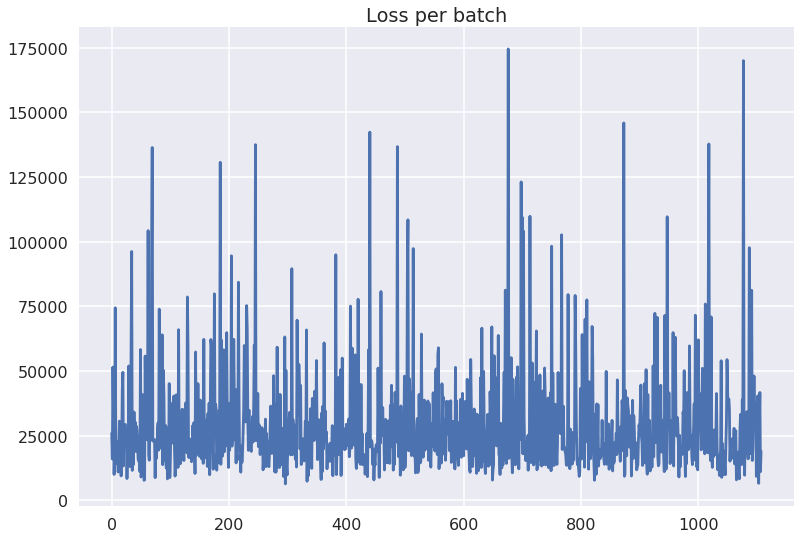

In [72]:
training, data, model, losses = run_network(data=data, epochs=2, batch=1024,n_timesteps=10)
trainX, trainY, testX, testY = data
plot_losses(losses)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


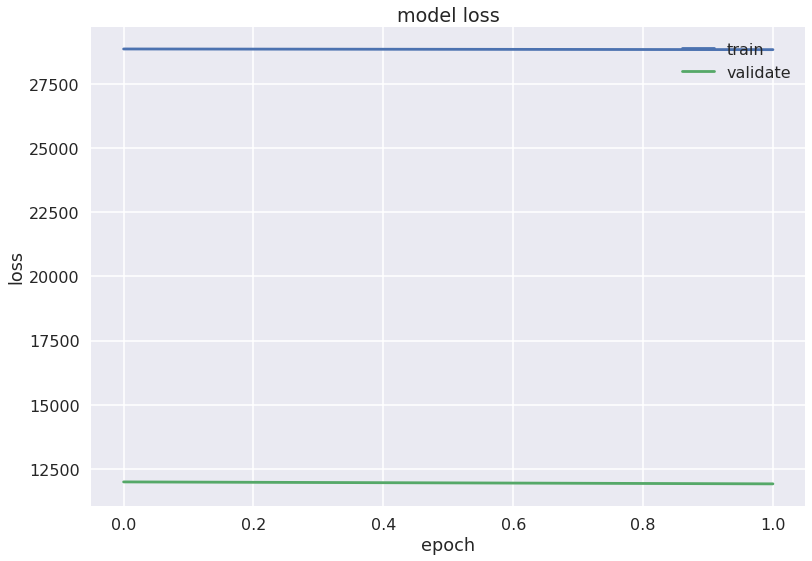

In [73]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

Results: MSE - 18870.275730  ;  seconds = 137.369
Train score MSE - 27130.865330 ; seconds = 164.714
[ 48.93046188]


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


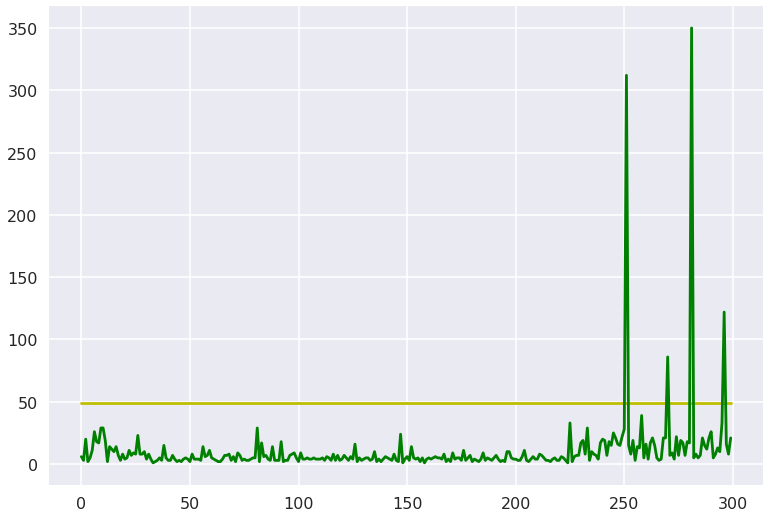

In [75]:
# trainX, trainY, testX, testY = data
# score = model.evaluate(testX, testY, verbose=1)
print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))
# train_score = model.evaluate(trainX, trainY, verbose =1)
print('Train score MSE - {:.6f} ; seconds = {:.3f}'.format(train_score, np.sqrt(train_score)))

predictions=model.predict(testX)
print(np.unique(predictions))
plt.plot(predictions[0:300],'y' )
plt.plot(testY[0:300], 'g')

plt.show()

3687.06953812 -48.9304618835


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


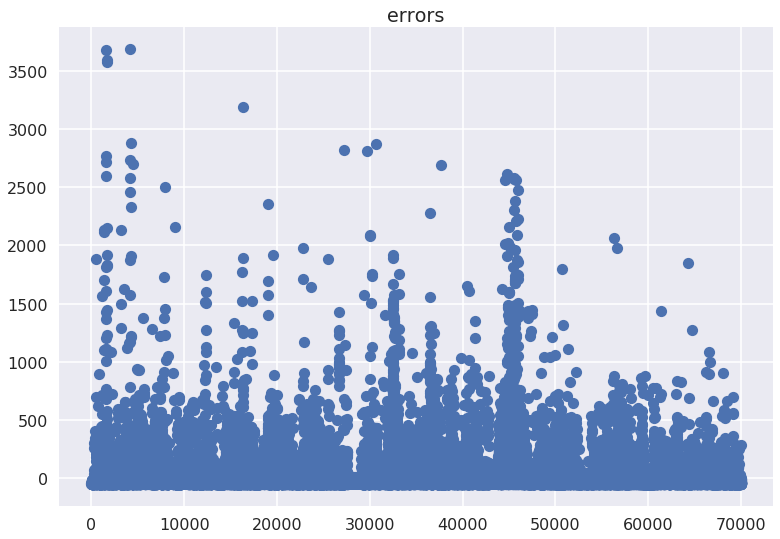

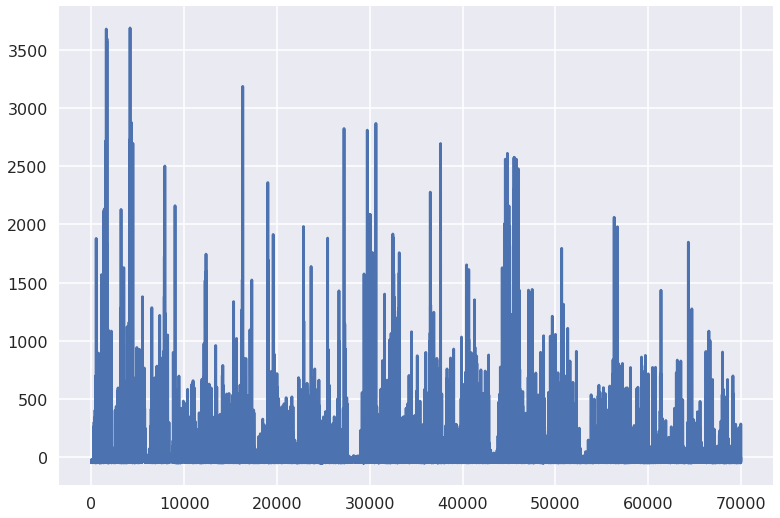

In [76]:
mae=np.subtract(np.reshape(testY, [len(testY), 1]), predictions)
print(np.max(mae), np.min(mae))

plt.plot(mae, 'o')
plt.title('errors')
plt.show()

plt.plot(mae)
plt.show()

# Going one layer deeper - 

In [ ]:
def build_model(num_timesteps=50):

    model = Sequential()
    layers = [512, 512, 256, 256, 128, 64, 1] 
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 10), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[5]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[6]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [ ]:
x, y = get_and_preprocess_data()
data = split_data(x,y, num_timesteps=30)


In [ ]:
training, data, model, losses = run_network(data=data, epochs=2, batch=1024,n_timesteps=10)
trainX, trainY, testX, testY = data
plot_losses(losses)